In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

### Load data and Preprocessing

In [3]:
(x_train,y_train), (x_test,y_test)= mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

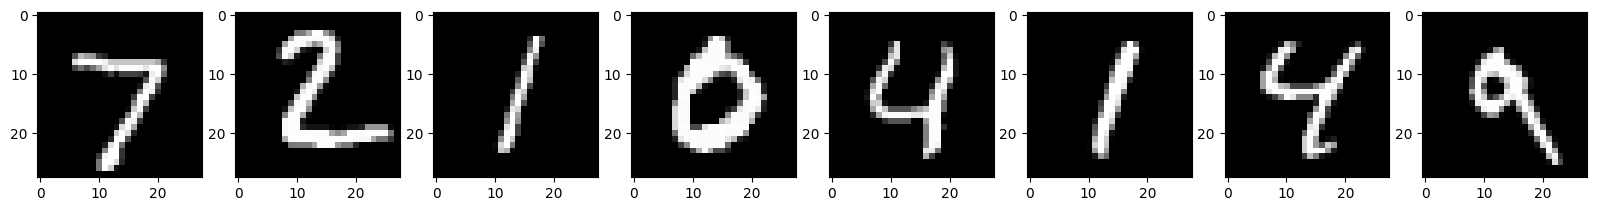

In [6]:
count=8
plt.figure(figsize=(20,10))

for i in range(count):
    ax = plt.subplot(2, count, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
plt.show()

In [7]:
import numpy as np

In [8]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.losses import binary_crossentropy

In [11]:
actual_dim=28*28
bottleneck_dim=64
latent_dim=2

### 

In [12]:
inputs =Input(shape=(actual_dim,))
h = Dense(bottleneck_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)     

### Distribution Parameters

In [13]:
from tensorflow.keras import backend as K

### Normal Distribution

In [14]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [15]:
z = Lambda(sampling)([z_mean, z_log_sigma])

### Encoder

In [16]:
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [17]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

decoding_1 = Dense(bottleneck_dim, activation='relu')(latent_inputs)

outputs = Dense(actual_dim, activation='sigmoid')(decoding_1)

### Decoder

In [18]:
decoder = Model(latent_inputs, outputs, name='decoder')

### VAE Model

In [19]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

### Loss Function

In [20]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *=  actual_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [21]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [22]:
vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 187.8471 - val_loss: 170.0957
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 167.6836 - val_loss: 165.0046
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 163.4861 - val_loss: 162.2685
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 160.9744 - val_loss: 160.2854
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 159.2037 - val_loss: 158.8599
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 157.7829 - val_loss: 157.9501
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 156.5804 - val_loss: 156.3281
Epoch 8/100
1875/1875 [==============================] - 9s 5ms/step - loss: 155.5699 - val_loss: 155.6345
Epoch 9/100
1875/1875 [==============================] - 9s 5ms/step - loss: 154.7173 - val_loss: 154.6001
Epoch 10/100
1875/1875 [============

Epoch 77/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.6465 - val_loss: 146.5074
Epoch 78/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.5796 - val_loss: 146.2949
Epoch 79/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.5457 - val_loss: 146.4021
Epoch 80/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.5046 - val_loss: 146.4916
Epoch 81/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.4586 - val_loss: 146.0856
Epoch 82/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.4210 - val_loss: 146.3584
Epoch 83/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.3813 - val_loss: 146.1682
Epoch 84/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.3492 - val_loss: 146.1551
Epoch 85/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.2864 - val_loss: 146.1828
Epoch 86/100
1875/1875 [====

In [23]:
encoded = encoder.predict(x_test, batch_size=32)

313/313 [==============================] - 1s 3ms/step


In [24]:
encoded_n=np.array(encoded)

In [25]:
encoded_n.shape, y_test.shape

((3, 10000, 2), (10000,))

In [26]:
encoded_n[:,:, 0]

array([[-1.8577812 , -0.0133964 ,  1.1458898 , ..., -0.5051035 ,
         1.5005994 ,  0.6918192 ],
       [-0.60013056, -1.7407013 , -1.2570177 , ..., -1.4380288 ,
        -0.8170775 , -1.3547187 ],
       [-1.8934599 , -0.03214867,  1.1270207 , ..., -0.474765  ,
         1.5301098 ,  0.71660084]], dtype=float32)

### Distribution

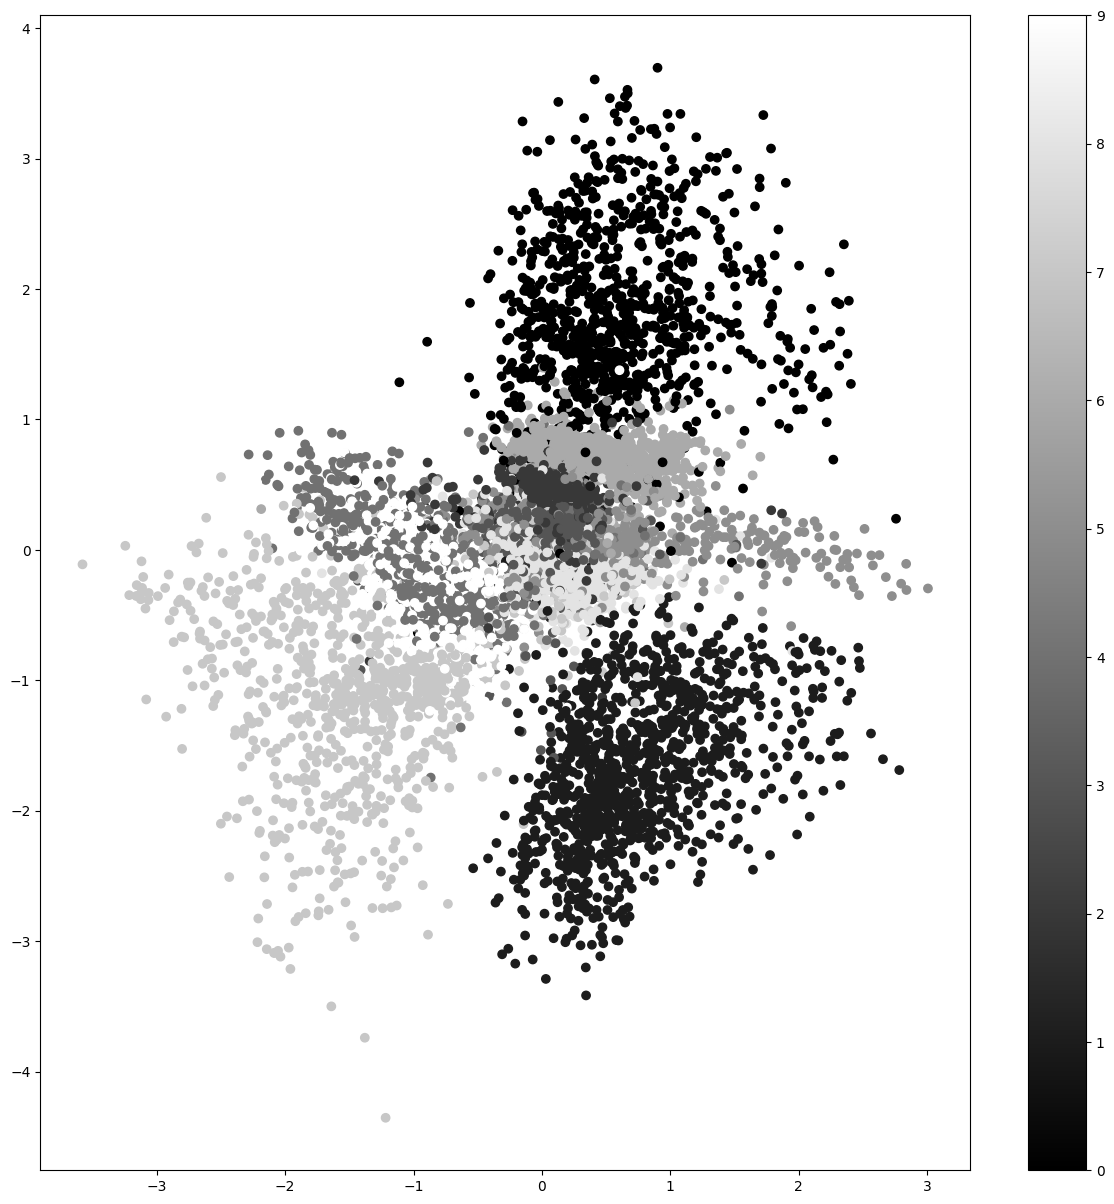

In [27]:
plt.figure(figsize=(15, 15))
plt.scatter(encoded_n[0,:, 0], encoded_n[0,:, 1], c=y_test)
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


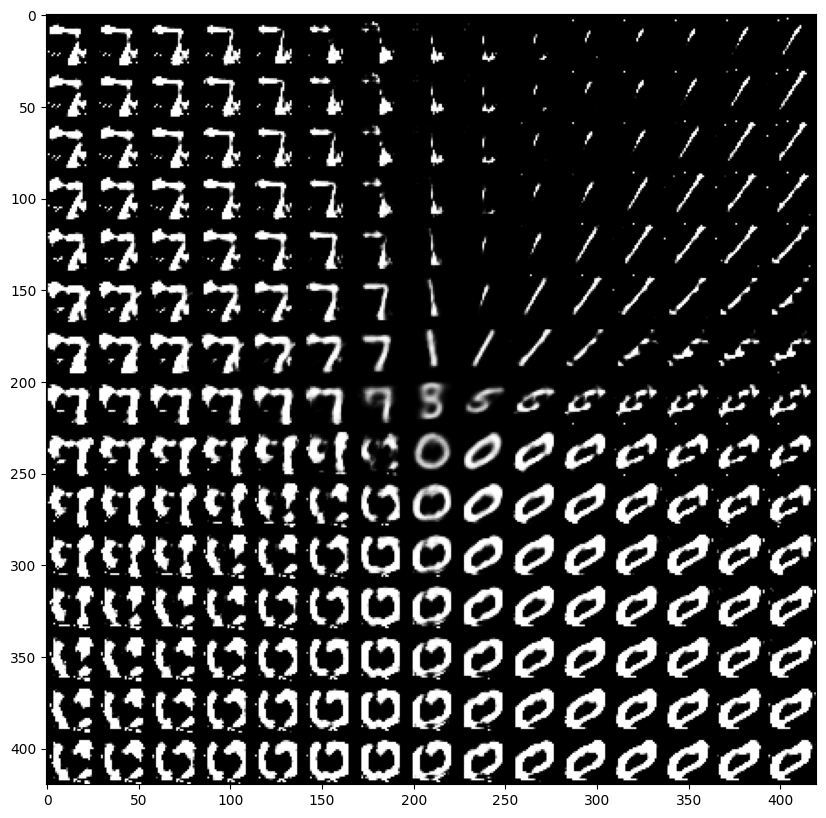

In [28]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    #print(yi)
    for j, xi in enumerate(grid_y):
        #print(xi)
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()